# 📒 Bulldozer Auction Price Prediction

In this notebook, we're going to go through a machine learning project with the goal of predicting the sale price of bulldozers.

**📌 Problem Definition**

> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?                                                                                                                                                      

**Data**                                                                      
The data is taken from kaggle blue Book for Bulldozers.

**Goal**

Minimizing RMSLE between predicted and the actual sale price of bulldozers.                                                                   

## 🔧 Imports

In [ ]:
# importing dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error,mean_absolute_error,r2_score
import joblib

## 📂 Load Data

In [ ]:
# downloading dataset from GitHub as a zip file.

!wget https://github.com/george-edwin/bulldozer-price-prediction/raw/main/Train.zip

import os
import zipfile

local_zip = 'Train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('.') # extracting all data into current working directory
zip_ref.close()

--2025-08-16 04:50:13--  https://github.com/mrdbourke/zero-to-mastery-ml/raw/master/data/bluebook-for-bulldozers.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/zero-to-mastery-ml/master/data/bluebook-for-bulldozers.zip [following]
--2025-08-16 04:50:13--  https://raw.githubusercontent.com/mrdbourke/zero-to-mastery-ml/master/data/bluebook-for-bulldozers.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72042477 (69M) [application/zip]
Saving to: ‘bluebook-for-bulldozers.zip’

bluebook-for-bulldo 100%[===================>]  68.70M   241MB/s    in 0.3s    

2025-08-16 04:50:14 (241

In [ ]:
# creating a dataframe using read_csv()

df = pd.read_csv('/content/Train.csv',low_memory='false',parse_dates=['saledate'])

df.head()

/tmp/ipython-input-2863664579.py:3: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/bluebook-for-bulldozers/Train.csv',low_memory='false',parse_dates=['saledate'])


,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##📊 Exploratory Data Analysis (EDA)

In [ ]:
# checking numerical features

df.describe()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saledate
count,4.011250e+05,401125.000000,4.011250e+05,401125.000000,401125.000000,380989.000000,401125.000000,1.427650e+05,401125
mean,1.919713e+06,31099.712848,1.217903e+06,6889.702980,134.665810,6.556040,1899.156901,3.457955e+03,2004-08-02 07:47:13.986413184
min,1.139246e+06,4750.000000,0.000000e+00,28.000000,121.000000,0.000000,1000.000000,0.000000e+00,1989-01-17 00:00:00
25%,1.418371e+06,14500.000000,1.088697e+06,3259.000000,132.000000,1.000000,1985.000000,0.000000e+00,2000-10-07 00:00:00
50%,1.639422e+06,24000.000000,1.279490e+06,4604.000000,132.000000,2.000000,1995.000000,0.000000e+00,2006-03-23 00:00:00
75%,2.242707e+06,40000.000000,1.468067e+06,8724.000000,136.000000,4.000000,2000.000000,3.025000e+03,2009-03-24 00:00:00
max,6.333342e+06,142000.000000,2.486330e+06,37198.000000,172.000000,99.000000,2013.000000,2.483300e+06,2011-12-30 00:00:00
std,9.090215e+05,23036.898502,4.409920e+05,6221.777842,8.962237,16.976779,291.797469,2.759026e+04,NaN


(401125, 53)


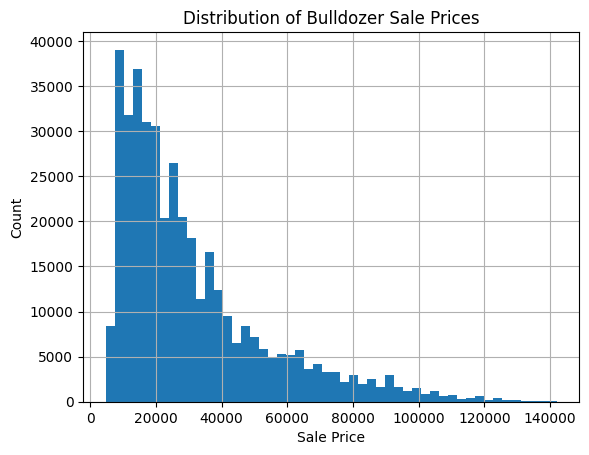

In [ ]:
# distribution of SalePrice

print(df.shape)
df["SalePrice"].hist(bins=50)
plt.title("Distribution of Bulldozer Sale Prices")
plt.xlabel("Sale Price")
plt.ylabel("Count")
plt.show()

Distribution of SalePrice

> Bulldozer prices are right skewed with most prices under $100,000.

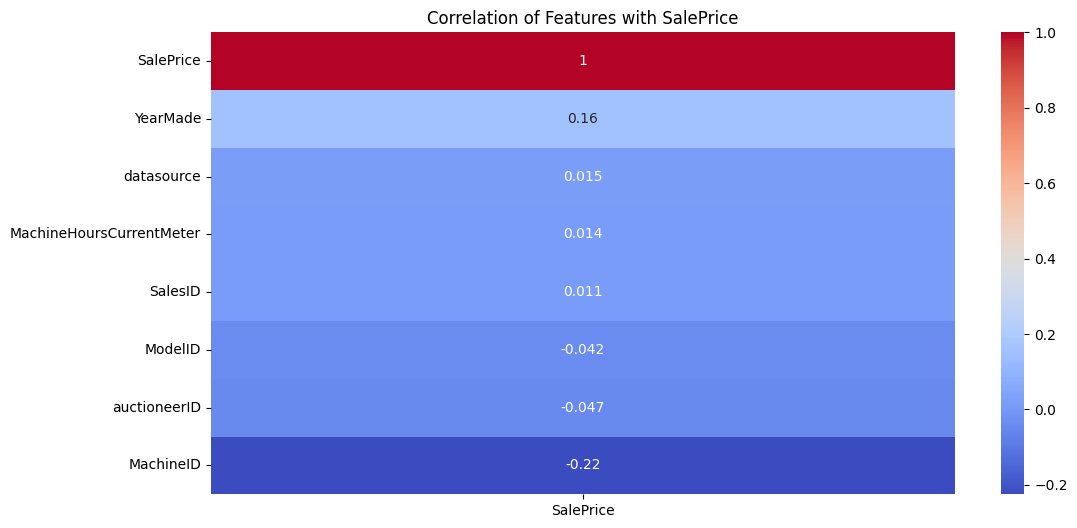

In [ ]:
# Correlation heatmap for numeric features

plt.figure(figsize=(12,6))
sns.heatmap(df.corr(numeric_only=True)["SalePrice"].sort_values(ascending=False).to_frame(), annot=True, cmap="coolwarm")
plt.title("Correlation of Features with SalePrice")
plt.show()

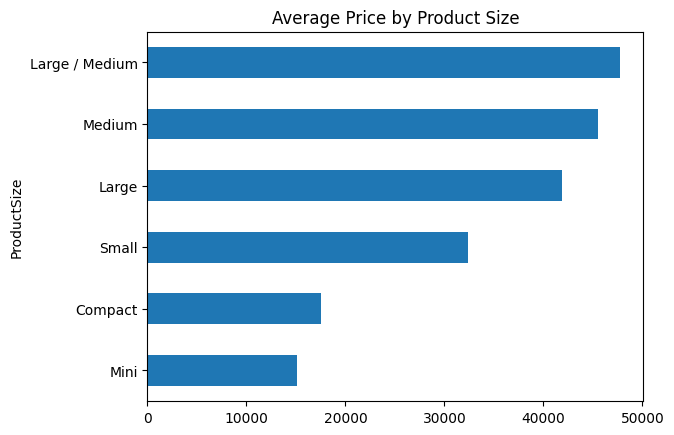

In [ ]:
# Average price by ProductSize

df.groupby("ProductSize")["SalePrice"].mean().sort_values().plot(kind="barh")
plt.title("Average Price by Product Size")
plt.show()

Average price by ProductSize

> Larger machines generally sell for higher prices, confirming that machine capacity is a key driver of value.

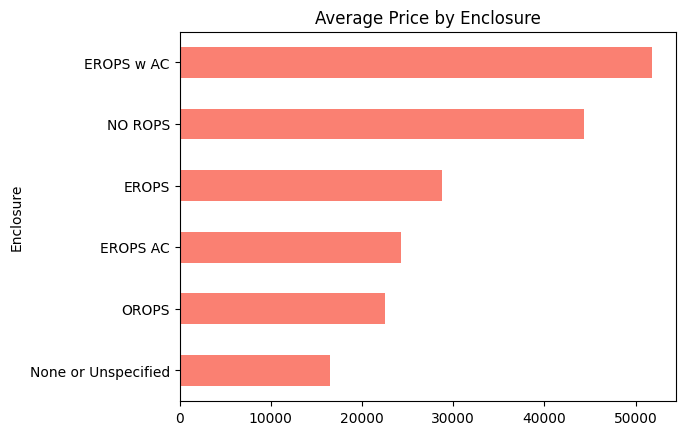

In [ ]:
# Average price by Enclosure type

df.groupby("Enclosure")["SalePrice"].mean().sort_values().plot(kind="barh",color='salmon')
plt.title("Average Price by Enclosure")
plt.show()

Average price by Enclosure

> Machines with enclosed ROPS and AC offer better comfort and safety, hance are more expensive compared to other models.

## 🧹 Data Cleaning & Feature Engineering

### Sorting dataset by date and adding new features.

In [ ]:
# first 10 rows of our dataset

df.head(10)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1139255,26500,1001274,4605,121,3.0,2004,508.0,Low,2008-12-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1139256,21000,772701,1937,121,3.0,1993,11540.0,High,2004-08-26,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
7,1139261,27000,902002,3539,121,3.0,2001,4883.0,High,2005-11-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1139272,21500,1036251,36003,121,3.0,2008,302.0,Low,2009-08-27,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
9,1139275,65000,1016474,3883,121,3.0,1000,20700.0,Medium,2007-08-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional


### Data Cleaning

In [ ]:
# replacing yearmade = 1000 by np.nan

dfsmall['YearMade'] = dfsmall['YearMade'].replace(1000,np.nan)

# adding a missing flag

dfsmall['YearMade_missing'] = dfsmall['YearMade'].isna().astype('int8')

# creating an age column

dfsmall['age'] = dfsmall['saleyear'] - dfsmall['YearMade']

# some values are negative in the age column so we clip them

dfsmall['age'].clip(lower=0,inplace=True)

# checking once again for negative values

print(f'Number of negative values in age column : {(dfsmall.age < 0).sum()}')

# checking out the values in age column

print(dfsmall.age.value_counts().sort_index())

Number of negative values in age column : 0
age
0.0       20
1.0       69
2.0      545
3.0     1913
4.0     4210
        ... 
59.0       1
60.0       1
90.0       1
91.0       6
92.0       9
Name: count, Length: 61, dtype: int64


/tmp/ipython-input-821837738.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfsmall['age'].clip(lower=0,inplace=True)


In [ ]:
# checking the number of null values in each column of the dataframe.

dfsmall.isna().mean()

,0
SalesID,0.000000
SalePrice,0.000000
MachineID,0.000000
ModelID,0.000000
datasource,0.000000
auctioneerID,0.000000
YearMade,0.112631
MachineHoursCurrentMeter,0.275927
UsageBand,0.529503
fiModelDesc,0.000000


In [ ]:
# dropping columns having more than 90% null values.

thresh = 0.90

drop_cols = [c for c in dfsmall.columns if (dfsmall[c].isna().mean()) > thresh]
dfsmall.drop(columns=drop_cols,inplace=True,axis=1)

# printing dropped columns

print(f'Dropped columns : {drop_cols}')

Dropped columns : ['Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Pushblock', 'Scarifier', 'Tip_Control']


### Dealing with missing values and Encoding

In [ ]:
# finding numerical columns with null values

num_cols=[]
for col,content in dfsmall.items():
  if pd.api.types.is_numeric_dtype(content):
    if pd.isnull(content).sum():
      num_cols.append(col)

print(f'Numerical Columns with null values : {num_cols}')

Numerical Columns with null values : ['YearMade', 'MachineHoursCurrentMeter', 'age']


In [ ]:
# filling numeric columns with median of that particular column

for col,content in dfsmall.items():
  if pd.api.types.is_numeric_dtype(content):
    if pd.isnull(content).sum():
      median_val=content.median()
      dfsmall[col]=content.fillna(median_val)

In [ ]:
# turning categorical variables into numbers and filling missing values.

for label,content in dfsmall.items():
    if not pd.api.types.is_numeric_dtype(content):
        # turn categories into numbers and adding 1 because for missing values pandas stores -1.
        dfsmall[label] = pd.Categorical(content).codes+1

In [ ]:
# checking if missing values still remain

if (dfsmall.isna().sum().sum() == 0):
  print('No null values remain in the dataset !')
else:
  print('Null values still remain in the dataset.')

No null values remain in the dataset !


##🤖 Model Training

### Splitting Dataset

In [ ]:
# spliting into testing and training sets.

# setting aside 10% of the dataset for testing and evaluating our model.
test_size = int(len(dfsmall) * 0.10)

train_df = dfsmall.iloc[:-test_size]
test_df   = dfsmall.iloc[-test_size:]

print(f"Training set size: {len(train_df)}")
print(f"Testing set size: {len(test_df)}")

# Spliting features/targets for training and testing

x_train = train_df.drop('SalePrice', axis=1)
y_train = train_df['SalePrice']

x_test = test_df.drop('SalePrice', axis=1)
y_test = test_df['SalePrice']


Training set size: 61729
Testing set size: 6858


### Evaluation Metric

In [ ]:
# creating a function to calculate root mean squared log error (RMSLE).

def rmsle(y_test,y_preds):
  return np.sqrt(mean_squared_log_error(y_test,y_preds))

# creating a function to calculate evaluation metrics on the training and testing sets and display it.

def show_scores(model):
  train_preds = model.predict(x_train)
  val_preds = model.predict(x_test)

  scores = {
      'Training MAE':mean_absolute_error(y_train,train_preds),
      'Testing MAE':mean_absolute_error(y_test,val_preds),
      'Training RMSLE':rmsle(y_train,train_preds),
      'Testing RMSLE':rmsle(y_test,val_preds),
      'Training r2_score':r2_score(y_train,train_preds),
      'Testing r2_score':r2_score(y_test,val_preds),
  }

  return scores

In [ ]:
# instantiating the Random Forest Regressor.

model = RandomForestRegressor(n_jobs=-1,random_state=42)

# fitting our model on the training set.

model.fit(x_train,y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [ ]:
# evaluating our model.

print('Evaluation metrics....\n')
baseline_preds = show_scores(model)
for key,value in baseline_preds.items():
  print(f"{key} : {value:,.3f}")

Evaluation metrics....

Training MAE : 1,673.258
Testing MAE : 6,092.409
Training RMSLE : 0.089
Testing RMSLE : 0.256
Training r2_score : 0.987
Testing r2_score : 0.869


###⚙️ Hyperparameter Tuning using RandomizedSearchCV

In [ ]:
# hyperparameter tuning using RandomizedSearchCV.


# creating parameter dictionary containing values of various hyperparameters.

rf_grid = {
    'n_estimators':np.arange(10,100,10),
    'max_depth':[None,10,20,30],
    'min_samples_split':np.arange(10,20,1),
    'min_samples_leaf':np.arange(1,5,1),
    'max_features':['auto','sqrt',0.5,1],
    'max_samples':[None]
}

# instantiating the randomized search cross validation model.

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,random_state=42),
                             param_distributions=rf_grid,
                             n_iter=7,cv=3,verbose=0)

# fitting our rs_model on the training set.

rs_model.fit(x_train,y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
9 fits failed out of a total of 21.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_pa

RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=7,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt', 0.5,
                                                         1],
                                        'max_samples': [None],
                                        'min_samples_leaf': array([1, 2, 3, 4]),
                                        'min_samples_split': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])})

In [ ]:
# evaluating our model.

print('Evaluation metrics....\n')
rs_model_preds = show_scores(rs_model)
for key,value in rs_model_preds.items():
  print(f"{key} : {value:,.3f}")

Evaluation metrics....

Training MAE : 5,976.968
Testing MAE : 7,112.736
Training RMSLE : 0.271
Testing RMSLE : 0.290
Training r2_score : 0.855
Testing r2_score : 0.823


In [ ]:
print('Best parameters of our randomized search model (rs_model)...')
print(rs_model.best_params_)

Best parameters of our randomized search model (rs_model)...
{'n_estimators': np.int64(40), 'min_samples_split': np.int64(18), 'min_samples_leaf': np.int64(2), 'max_samples': None, 'max_features': 0.5, 'max_depth': 10}


In [ ]:
# trying out a different set of hyperparameters.

rf_grid2 = {
    'n_estimators':np.arange(50,300,50),
    'max_depth':[None,10,20,30],
    'min_samples_split':np.arange(2,20,2),
    'min_samples_leaf':np.arange(1,5,1),
    'max_features':['auto','sqrt',0.5,1],
    'max_samples':[None,0.8,0.6]
}

# instantiating random search cv model rs_model2.

rs_model2 = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,random_state=42),
                             param_distributions=rf_grid2,
                             n_iter=7,cv=3,verbose=1)

# fitting our model on the training data.
rs_model2.fit(x_train,y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
6 fits failed out of a total of 21.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_pa

RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=7,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt', 0.5,
                                                         1],
                                        'max_samples': [None, 0.8, 0.6],
                                        'min_samples_leaf': array([1, 2, 3, 4]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250])},
                   verbose=1)

In [ ]:
# evaluating our model.

print('Evaluation metrics....\n')
rs_model2_preds = show_scores(rs_model2)
for key,value in rs_model2_preds.items():
  print(f"{key} : {value:,.3f}")

Evaluation metrics....

Training MAE : 3,334.123
Testing MAE : 6,053.209
Training RMSLE : 0.164
Testing RMSLE : 0.256
Training r2_score : 0.953
Testing r2_score : 0.870


In [ ]:
print('Best parameters of our randomized search model (rs_model2)')
print(rs_model2.best_params_)

Best parameters of our randomized search model (rs_model2)
{'n_estimators': np.int64(250), 'min_samples_split': np.int64(2), 'min_samples_leaf': np.int64(2), 'max_samples': 0.8, 'max_features': 'sqrt', 'max_depth': 20}


In [ ]:
# trying out a third set of hyperparameters based on the above two models.

rf_grid3 = {
    'n_estimators': [70, 100, 150, 200, 250],
    'max_depth': [None, 15, 20, 25],
    'min_samples_split': [6, 8, 10, 12, 14],
    'min_samples_leaf': [1, 2],
    'max_features': [0.5, 'sqrt'],
    'max_samples': [None, 0.8, 0.9]
}

# instantiating a randomized search cv model (rs_model3).

rs_model3 = RandomizedSearchCV(
    RandomForestRegressor(n_jobs=-1, random_state = 42),
    param_distributions=rf_grid3,
    n_iter=10,
    cv=3,
    verbose=1
)

# fiting our model on the training set.

rs_model3.fit(x_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   param_distributions={'max_depth': [None, 15, 20, 25],
                                        'max_features': [0.5, 'sqrt'],
                                        'max_samples': [None, 0.8, 0.9],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [6, 8, 10, 12, 14],
                                        'n_estimators': [70, 100, 150, 200,
                                                         250]},
                   verbose=1)

## 📈 Evaluation

In [ ]:
# evaluating our model.

print('Evaluation metrics....\n')
rs_model3_preds = show_scores(rs_model3)
for key,value in rs_model3_preds.items():
  print(f"{key} : {value:,.3f}")

Evaluation metrics....

Training MAE : 2,786.767
Testing MAE : 5,892.722
Training RMSLE : 0.138
Testing RMSLE : 0.248
Training r2_score : 0.965
Testing r2_score : 0.878


In [ ]:
print('Best parameters of our randomized search model (rs_model3)')
print(rs_model3.best_params_)

Best parameters of our randomized search model (rs_model3)
{'n_estimators': 100, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_samples': 0.8, 'max_features': 0.5, 'max_depth': 25}


## 📂 Saving our Model

In [ ]:
# saving our model using joblib

joblib.dump(rs_model3, "bulldozer_best_model.joblib")
print("Model saved to bulldozer_best_model.joblib")

NameError: name 'rs_model3' is not defined

In [ ]:
# loading the saved model

model = joblib.load('/content/bulldozer_best_model.joblib')

##📊 Comparing Baseline Model vs Tuned Model

In [ ]:
print('Tuned Model vs Baseline Model !')

for key in baseline_preds:
  old_val = baseline_preds[key]
  new_val = model_preds[key]
  if 'Testing' in key:
    if 'r2' in key:
      t = (new_val-old_val)/(1-old_val)*100
    else:
      t = (old_val-new_val)/(old_val)*100
    print(f'{key} : {t:+.1f}%')


Best Model vs Baseline Model !
Testing MAE : +3.3%
Testing RMSLE : +3.2%
Testing r2_score : +7.0%


### 📈 Predicted vs Actual Scatter Plot

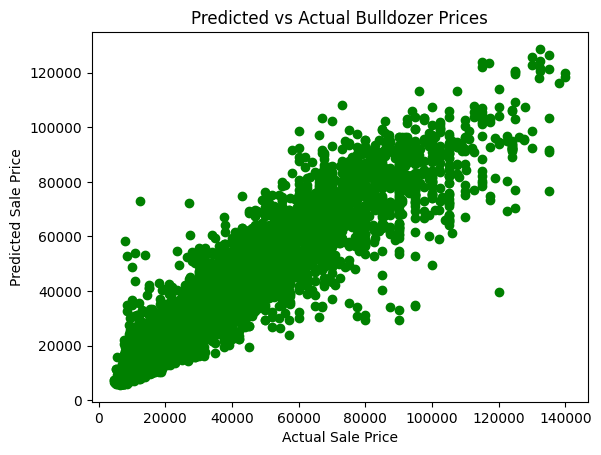

In [ ]:
# Predicted vs Actual
plt.scatter(y_test, model.predict(x_test),color='green')
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Predicted vs Actual Bulldozer Prices")
plt.show()

Actual vs Predicted SalePrice

> The scatter plot shows that most predictions align well with the actual sale prices, indicating the model captures the overall trend. However, the spread suggests some prediction errors, especially at higher price ranges, which is expected due to the skewed nature of the target variable.

## ⚙️ Feature Importance

In [ ]:
def plot_features(columns, importances, n=20):
    """Plot horizontal bar-chart of top-n feature importances."""

    df = (pd.DataFrame({'features': columns,
                        'feature_importances': importances})
            .sort_values('feature_importances', ascending=False)
            .reset_index(drop=True))

    fig, ax = plt.subplots()
    ax.barh(df['features'][:n], df['feature_importances'][:n])
    ax.set_xlabel('Feature importance')
    ax.set_ylabel('Features')
    ax.set_title('Top 20 features')
    ax.invert_yaxis()          # highest on top
    plt.show()

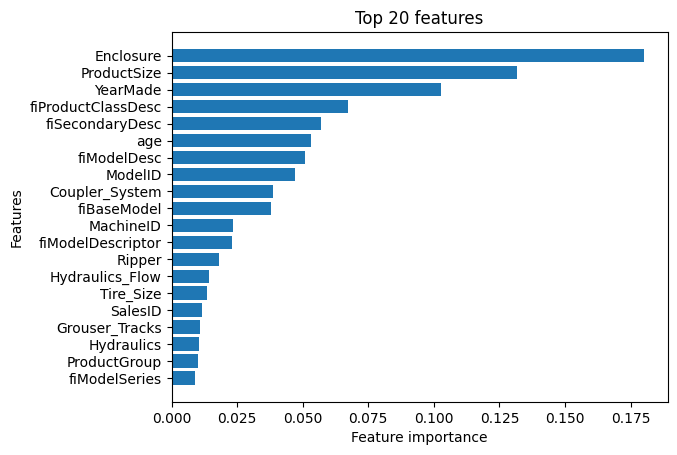

In [ ]:
plot_features(x_train.columns,model.best_estimator_.feature_importances_)

The above plot shows the top features influencing bulldozer sale prices according to our Random Forest model.

**Enclosure** (whether the bulldozer has an open cab, standard cab, etc.) is the most influential factor in determining auction price. Machines with enclosed cabs often sell for higher prices because they provide better operator comfort and protection.

**ProductSize** is also highly predictive — larger, more powerful bulldozers generally command higher prices at auction.

**YearMade** and the derived **Age** feature still play a role, but are less dominant compared to enclosure and product size.

👉 These results make sense from a business perspective: **buyers value comfort, protection, and machine size when bidding, in addition to age and market timing**.

## 📌 Conclusion

* EDA showed a skewed target and key drivers like ProductSize and Enclosure.

* Random Forest model with hyperparameter tuning achieved strong predictive accuracy.

* Feature importance confirmed machine specs and age as major price factors.

Overall, **the model effectively predicts bulldozer sale prices while providing interpretable business insights.**